<a href="https://colab.research.google.com/github/hadil1999-creator/Summer-Internship-at-Innov-com/blob/main/Copy_of_INNOV'COM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project (3 parts):

1-Face detection

2-Facial Recognition

3-Emotion detection

*Installations needed for the whole project*

In [ ]:
import numpy as np
import tensorflow as tf
import os
import PIL
import PIL.Image
import pandas as pd

In [ ]:
print(tf.__version__)

2.8.2


---We are going to use Kaggle datasets, upload them to our notebook using Kaggle API---

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

*Part1: Face detection*

In [ ]:
#!kaggle datasets download -d stoicstatic/face-recognition-dataset

In [ ]:
#!unzip face-recognition-dataset.zip

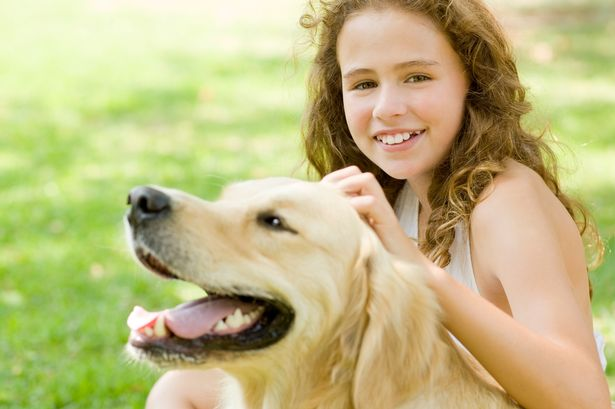

In [ ]:
from IPython.display import Image 
pil_img = Image(filename='/content/face.jpg')
display(pil_img)

1.1 Face detection using Haarcascade classifier

In [ ]:
import cv2
import sys

In [ ]:
cv2.__version__

'4.6.0'

---Haarcascade classifier already built in opencv---

In [ ]:
imagePath = sys.argv[1]
cascPath = "haarcascade_frontalface_default.xml"

--We can add specificities like eyes detection or anyother feature needed to future use--

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + cascPath)
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')


In [ ]:
image = cv2.imread('/content/face.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


In [ ]:
faces = face_cascade.detectMultiScale(gray, 1.1, 2)

In [ ]:
for (x,y,w,h) in faces:
    cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = image[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)


---Having all the code in one function---

In [ ]:
def detect(path):
  image = cv2.imread(path)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.1, 3)
  for (x,y,w,h) in faces:
    cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = image[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
  from google.colab.patches import cv2_imshow
  cv2_imshow(image)



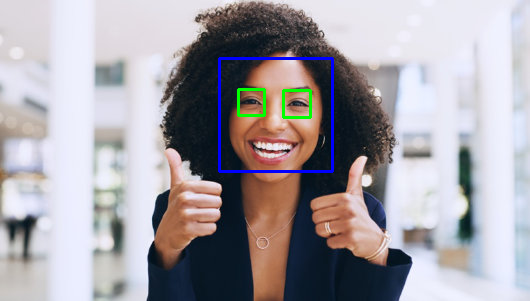

In [ ]:
detect('/content/face.jpg')


---Webcam captured images---




In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

---Helper functions of JS: convert images from javascript to opencv---

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

---Use code within Google Colab's **Code Snippets** that has a variety of useful code functions to perform various tasks.--

--We will be using the code snippet for **Camera Capture** to utilize your computer's webcam.--

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
#photo.jpg is the variable which will store the captured image
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray,1.1,3)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
      cv2.putText(img, 'Face', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


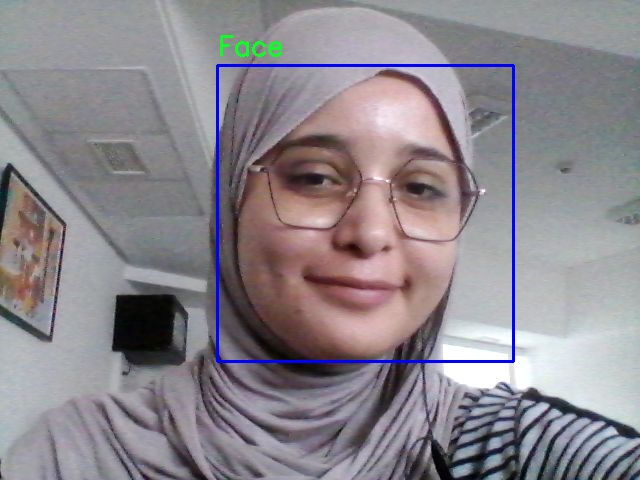

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))


except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
#it will give us the hight and width 
#it will save the capture into photo.jpg found in the left


---Real time videos---

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8) #the different thing between image capturing and video capturing

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray,1.1,3)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      cv2.putText(bbox_array, 'Face Detection', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes


<IPython.core.display.Javascript object>

1.2 Face detection using Yolov4

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15490, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 15490 (delta 10), reused 20 (delta 8), pack-reused 15460
Receiving objects: 100% (15490/15490), 14.08 MiB | 20.08 MiB/s, done.
Resolving deltas: 100% (10398/10398), done.


In [ ]:
# change makefile to have GPU, OPENCV and LIBSO enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [ ]:
# make darknet (builds darknet so that you can then use the darknet.py file and have its dependencies)
!make

In [ ]:
# get bthe scaled yolov4 weights file that is pre-trained to detect 80 classes (objects) from shared google drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

In [ ]:
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

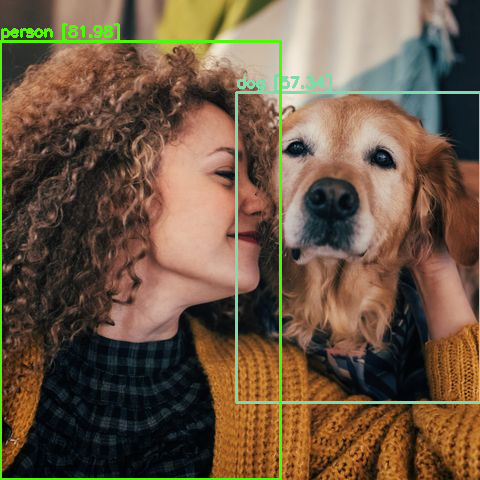

In [ ]:
# run test on person.jpg image that comes with repository
image = cv2.imread("/content/this.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
cv2_imshow(image)

---Webcam captured image---

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  
  # call our darknet helper on webcam image
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # loop through detections and draw them on webcam image
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


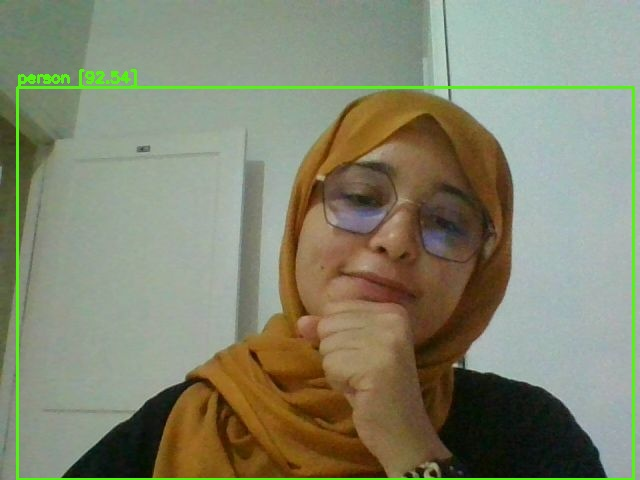

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

---Real time video---

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

*Part2: Facial recognition*

2.1 Downloading the Dataset

In [ ]:
! kaggle datasets download -d jessicali9530/lfw-dataset --force

 92% 103M/112M [00:00<00:00, 138MB/s] 
100% 112M/112M [00:00<00:00, 124MB/s]


In [ ]:
!unzip lfw-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0026.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0027.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0028.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0029.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Si

In [ ]:
from IPython.display import Image 
pil_img = Image(filename='/content/lfw-deepfunneled/lfw-deepfunneled/Wen_Jiabao/Wen_Jiabao_0006.jpg ')
display(pil_img)


*lfwallnames.csv: Contains all names of each face in the dataset along with number of images each face has.*

In [ ]:
!pip install split-folders


In [ ]:
import splitfolders
splitfolders.ratio('/content/lfw-deepfunneled/lfw-deepfunneled', output="output", seed=1337, ratio=(0.7, 0.1,0.2)) 

In [ ]:
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/lfw-deepfunneled', output="output", seed=1337, ratio=(0.7, 0.1,0.2)) 

In [ ]:
import cv2
im = cv2.imread('/content/lfw-deepfunneled/lfw-deepfunneled/AJ_Lamas/AJ_Lamas_0001.jpg')
print(type(im))
print(im.shape)
print(type(im.shape))


<class 'numpy.ndarray'>
(250, 250, 3)
<class 'tuple'>


In [ ]:
!rm -rf output

*Split data into an output directory*

In [ ]:
from keras.preprocessing import image
image_size = (48,48)
batch_size = 64
train1 = tf.keras.preprocessing.image_dataset_from_directory('/content/output/train', seed = 1000,image_size=image_size, batch_size = batch_size,color_mode='rgb')

Found 5727 files belonging to 5749 classes.


In [ ]:
test1 = tf.keras.preprocessing.image_dataset_from_directory('/content/output/test', seed = 1000,image_size=image_size,color_mode='rgb')

Found 7129 files belonging to 5749 classes.


In [ ]:
validation1 = tf.keras.preprocessing.image_dataset_from_directory('/content/output/val', seed = 1000,image_size=image_size,color_mode='rgb')

Found 377 files belonging to 5749 classes.


Build Models

In [ ]:
import os
from tensorflow import keras
from keras.models import Sequential
import keras
from keras import layers
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import Convolution2D, MaxPooling2D,AveragePooling2D,Dropout

*Checking the size of the dataset images*

In [ ]:
model1 = keras.Sequential()

model1.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,3),padding='same'))
model1.add(layers.MaxPooling2D(2,2))
model1.add(layers.Dropout(0.1, noise_shape=None, seed=None))


model1.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model1.add(layers.MaxPooling2D(2,2))
model1.add(layers.Dropout(0.1, noise_shape=None, seed=None))

model1.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(48,48,3),padding='same'))
model1.add(layers.MaxPooling2D(2,2))
model1.add(layers.Dropout(0.1, noise_shape=None, seed=None))


model1.add(layers.Flatten())

model1.add(layers.Dense(units=5749, activation = 'softmax'))

In [ ]:
for layer in model1.layers:
    print(layer.output_shape)

(None, 48, 48, 32)
(None, 24, 24, 32)
(None, 24, 24, 32)
(None, 22, 22, 64)
(None, 11, 11, 64)
(None, 11, 11, 64)
(None, 11, 11, 64)
(None, 5, 5, 64)
(None, 5, 5, 64)
(None, 1600)
(None, 5749)


In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 64)        0

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
#opt=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=1.0, nesterov=False, name="SGD")
model1.compile(optimizer=opt,loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', verbose=1, patience=1,mode="max")


In [ ]:
model1_fit = model1.fit(train1, epochs=30)

Epoch 1/30
90/90 [==============================] - 4s 40ms/step - loss: 1.7731 - accuracy: 0.5914
Epoch 2/30
90/90 [==============================] - 3s 30ms/step - loss: 1.7143 - accuracy: 0.6115
Epoch 3/30
90/90 [==============================] - 3s 30ms/step - loss: 1.7542 - accuracy: 0.5923
Epoch 4/30
90/90 [==============================] - 3s 30ms/step - loss: 1.7742 - accuracy: 0.5972
Epoch 5/30
90/90 [==============================] - 3s 31ms/step - loss: 1.7795 - accuracy: 0.5989
Epoch 6/30
90/90 [==============================] - 3s 30ms/step - loss: 1.6366 - accuracy: 0.6108
Epoch 7/30
90/90 [==============================] - 3s 30ms/step - loss: 1.6074 - accuracy: 0.6200
Epoch 8/30
90/90 [==============================] - 3s 31ms/step - loss: 1.6155 - accuracy: 0.6234
Epoch 9/30
90/90 [==============================] - 3s 32ms/step - loss: 1.6398 - accuracy: 0.6145
Epoch 10/30
90/90 [==============================] - 3s 31ms/step - loss: 1.6134 - accuracy: 0.6174
Epoch 11/

In [ ]:
model1_evaluate = model1.evaluate(validation1)

12/12 [==============================] - 0s 8ms/step - loss: 11.5984 - accuracy: 0.1141


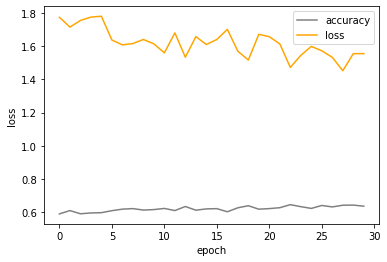

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model1_fit.history['accuracy'],color="grey")
plt.plot(model1_fit.history['loss'], color = "orange")
plt.ylabel('accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper right')
plt.savefig("my face archi plot")

In [ ]:
import joblib
import pickle
filename1 = "face recognition my archi.joblib"
joblib.dump(model1, filename1)
print("Saved model to disk")

In [ ]:
import joblib
import pickle
filename1 = "face recognition my archi.joblib"
loaded_model1 = joblib.load(filename1)
loaded_model1.summary()

In [ ]:
prediction1=model1.predict(test1)
prediction1

array([[5.2957129e-13, 6.0542180e-13, 4.8723899e-13, ..., 8.3312936e-13,
        5.3772817e-13, 1.0191529e-12],
       [1.0023051e-07, 7.0969094e-08, 1.8490324e-07, ..., 8.4903576e-08,
        1.0461020e-07, 4.6403855e-08],
       [1.5609545e-12, 1.0037687e-12, 2.9336531e-12, ..., 1.3318029e-12,
        1.6597776e-12, 4.6396242e-13],
       ...,
       [4.3279646e-14, 4.6881685e-14, 1.6540854e-14, ..., 4.1728936e-14,
        4.3390239e-14, 8.2216853e-14],
       [3.1489178e-16, 1.6303249e-16, 1.7223352e-15, ..., 3.9144836e-16,
        4.0680287e-16, 9.9265174e-17],
       [3.6112666e-10, 2.6953562e-10, 4.2839723e-10, ..., 3.4253250e-10,
        3.6770809e-10, 2.5366015e-10]], dtype=float32)

In [ ]:
df1 = pd.DataFrame(prediction1)
df1['predicted_person']= np.argmax(prediction1, axis=-1)
df1

In [ ]:
df1_sum = pd.DataFrame(df1['predicted_person'])
df1_sum

,predicted_person
0,5252
1,1871
2,385
3,3351
4,2920
...,...
7124,3704
7125,5627
7126,5338
7127,3967


In [ ]:
name= pd.read_csv('/content/people.csv')
name

In [ ]:
s = pd.Series([i for i in name['name']])
s

0           Abdel_Madi_Shabneh
1                 Abdul_Rahman
2                 Abel_Pacheco
3                 Adriana_Lima
4                  Afton_Smith
                 ...          
5753              Yves_Brodeur
5754               Zach_Pillar
5755    Zafarullah_Khan_Jamali
5756            Zara_Akhmadova
5757                Zhu_Rongji
Length: 5758, dtype: object

In [ ]:
index_to_name = dict((i,c) for i, c in enumerate(s))
index_to_name[1]

'Abdul_Rahman'

In [ ]:
for i in df1_sum['predicted_person']:
  df1_sum[i]=index_to_name(i)
df1_sum

TypeError: ignored

In [ ]:
for i, j in df1_sum.iterrows():
    replace(i,index_to_name(i))
    

NameError: ignored

Pretrained models

*CNN Model*

*LeNet5 Architecture*

*7 layers without considering the input layer*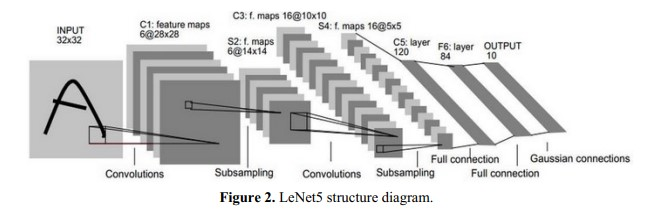

In [ ]:
from keras.preprocessing import image
image_size = (240,240)
batch_size = 32
train2 = tf.keras.preprocessing.image_dataset_from_directory('/content/output/train', seed = 1000,image_size=image_size, batch_size = batch_size,color_mode='rgb')

Found 5727 files belonging to 5749 classes.


In [ ]:
validation2 = tf.keras.preprocessing.image_dataset_from_directory('/content/output/val', seed = 1000,image_size=image_size, batch_size = batch_size,color_mode='rgb')

Found 377 files belonging to 5749 classes.


In [ ]:
test2 = tf.keras.preprocessing.image_dataset_from_directory('/content/output/test', seed = 1000,image_size=image_size, batch_size = batch_size,color_mode='rgb')

Found 7129 files belonging to 5749 classes.


In [ ]:
model2 = keras.models.Sequential([
    keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='relu', input_shape=(240,240,3)), 
    keras.layers.AveragePooling2D(), 
    keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='relu', padding='same'), 
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(120, kernel_size=5, strides=1, activation='relu', padding='same'),
    keras.layers.AveragePooling2D(),
    keras.layers.Flatten(), 
  
    keras.layers.Dense(84, activation='relu'), 
    keras.layers.Dense(5749, activation='softmax') 
])

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model2.compile(optimizer=opt, loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [ ]:
model2_fit=model2.fit(train2,epochs=5)

Epoch 1/5
179/179 [==============================] - 9s 47ms/step - loss: 10.1860 - accuracy: 0.0602
Epoch 2/5
179/179 [==============================] - 9s 46ms/step - loss: 6.7369 - accuracy: 0.0648
Epoch 3/5
179/179 [==============================] - 9s 47ms/step - loss: 6.6121 - accuracy: 0.0650
Epoch 4/5
179/179 [==============================] - 9s 47ms/step - loss: 6.5849 - accuracy: 0.0641
Epoch 5/5
179/179 [==============================] - 9s 48ms/step - loss: 6.5658 - accuracy: 0.0657


In [ ]:
model2.evaluate(validation2)


12/12 [==============================] - 1s 34ms/step - loss: 20.5437 - accuracy: 0.0769


[20.54374122619629, 0.07692307978868484]

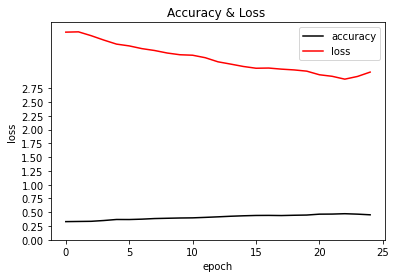

In [ ]:
plt.plot(model2_fit.history['accuracy'],color="black")
plt.plot(model2_fit.history['loss'], color = "red")
plt.title('Accuracy & Loss ')
plt.ylabel('accuracy')
plt.ylabel('loss')
plt.yticks(np.arange(0, 3, 0.25))
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper right')
plt.savefig("lenet plot")

In [ ]:
import joblib
import pickle
filename2 = "face recognition lenet5.joblib"
joblib.dump(model2, filename2)
print("Saved model to disk")

Saved model to disk


In [ ]:
import joblib
import pickle
filename2 = "face recognition lenet5.joblib"
loaded_model2 = joblib.load(filename2)
loaded_model2.summary()

In [ ]:
prediction2=model2.predict(test2)
prediction2.shape

(7129, 5749)

In [ ]:
df2 = pd.DataFrame(prediction2)
df2['predicted_person']= np.argmax(prediction2, axis=-1)
df2


,0,1,2,3,4,5,6,7,8,9,...,5740,5741,5742,5743,5744,5745,5746,5747,5748,predicted_person
0,9.715048e-21,1.056354e-20,3.020840e-22,1.997370e-22,2.188325e-21,3.477711e-36,3.344721e-23,0.000000e+00,1.993625e-22,4.337231e-24,...,3.033058e-29,3.617680e-22,2.705221e-22,1.550922e-27,6.046396e-23,2.369920e-21,3.641757e-23,1.833513e-21,7.455154e-21,2828
1,8.705651e-32,9.154821e-32,6.219010e-33,1.460617e-31,1.609838e-31,0.000000e+00,4.066768e-32,7.165609e-32,5.275578e-30,1.685987e-33,...,1.562490e-36,1.309732e-32,1.729549e-32,4.354577e-31,3.475906e-31,2.153338e-31,3.240283e-32,2.138284e-32,3.115484e-32,1871
2,7.732166e-12,1.930557e-11,7.410550e-12,9.207674e-12,6.911662e-12,1.580429e-13,9.827534e-13,1.928454e-16,1.068431e-11,2.653909e-13,...,5.889963e-17,1.654811e-12,3.355932e-12,1.844727e-16,3.343792e-12,4.877360e-12,1.087240e-12,3.357660e-12,1.261886e-11,5171
3,2.410260e-26,1.542456e-27,4.336072e-26,8.153154e-25,1.192319e-26,0.000000e+00,4.977119e-26,0.000000e+00,1.339549e-24,1.796166e-28,...,2.628248e-24,2.066569e-29,1.404574e-25,0.000000e+00,6.791124e-24,3.355044e-26,2.106046e-26,7.310248e-26,8.214651e-26,2721
4,7.995362e-25,9.213925e-23,6.318837e-28,8.421421e-27,7.200452e-26,4.978452e-38,3.000447e-28,0.000000e+00,3.600957e-27,2.092972e-28,...,3.728292e-11,2.986431e-24,1.275895e-27,0.000000e+00,5.108936e-29,2.879316e-25,9.440069e-28,1.419639e-26,3.043740e-25,3704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124,4.495280e-28,9.721684e-30,3.685686e-30,3.030646e-27,1.383733e-31,0.000000e+00,3.330771e-29,0.000000e+00,3.128509e-26,1.325577e-29,...,0.000000e+00,9.186486e-30,2.615800e-28,0.000000e+00,1.043352e-27,5.658926e-27,3.223952e-28,8.041931e-30,1.238155e-28,4836
7125,1.745049e-20,4.361964e-23,5.933787e-21,3.699026e-17,1.420402e-22,0.000000e+00,1.197941e-19,0.000000e+00,1.304877e-15,4.946061e-20,...,0.000000e+00,1.879432e-22,5.988479e-20,0.000000e+00,7.520139e-16,1.966089e-18,8.790679e-19,2.962826e-21,4.827522e-21,1047
7126,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1047
7127,5.168557e-18,2.397365e-19,1.032563e-16,2.253999e-18,7.057929e-17,0.000000e+00,9.073651e-20,6.546857e-28,1.186946e-17,6.694721e-22,...,2.729905e-29,3.118031e-21,6.228024e-19,1.905010e-14,2.557548e-18,1.028160e-18,1.348328e-20,2.154782e-17,2.041212e-17,4566


In [ ]:
df2_sum = pd.DataFrame(df2['predicted_person'])
df2_sum

,predicted_person
0,2828
1,1871
2,5171
3,2721
4,3704
...,...
7124,4836
7125,1047
7126,1047
7127,4566


3/Emotion Recognition 

3.1 Downloading the Dataset from kaggle

In [ ]:
! kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 99% 119M/121M [00:04<00:00, 35.5MB/s]
100% 121M/121M [00:04<00:00, 29.0MB/s]


In [ ]:
!unzip face-expression-recognition-dataset.zip


In [ ]:
!rm -rf images/images

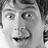

(48, 48, 3)

In [ ]:
from IPython.display import Image 
pil_img = Image(filename='images/validation/surprise/993.jpg')
display(pil_img)
import cv2
img = cv2.imread('images/validation/surprise/993.jpg')
img.shape
#resized_image = tf.image.resize(img, (48, 48))
#resized_image.shape



In [ ]:
from keras.preprocessing import image
image_size = (48,48)
batch_size = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory('images/train', seed = 1000,batch_size = batch_size, image_size=image_size,color_mode='rgb')


Found 28821 files belonging to 7 classes.


In [ ]:
test_data = tf.keras.preprocessing.image_dataset_from_directory('images/validation', seed = 1000,image_size=image_size,color_mode='rgb')

Found 7066 files belonging to 7 classes.


*Visualising the data*

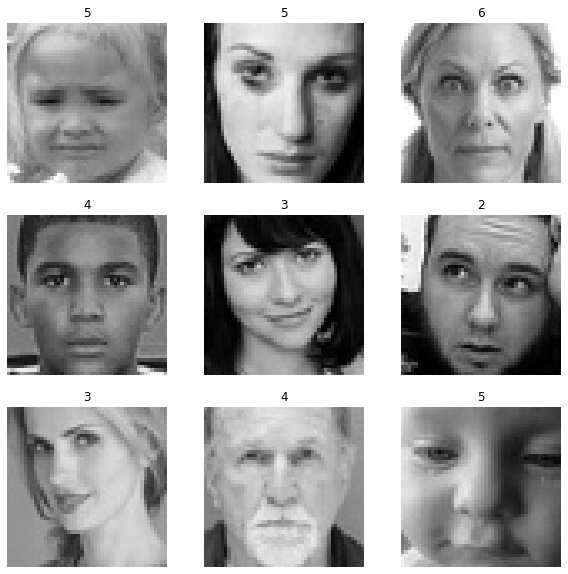

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for images, labels in train_data.take(1):
  for i in range(9):
     ax = plt.subplot(3,3, i+1)
     plt.imshow(images[i].numpy().astype("uint8"))
     plt.title(int(labels[i]))
     plt.axis("off")

3.2 Defining the classes

*Giving every class a numerical*

In [ ]:
classes = ['angry','disgust','fear','happy','neutral','sad','surprise']
class_to_index = dict((c,i) for i, c in enumerate(classes))
class_to_index

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

*Case studying*

In [ ]:
switcher={
    0: 'anger',
    1 : 'disgust',
    2: 'fear',
    3:'happy',
    4:'neutral',
    5:'sad',
    6:'surprise',
    
}
def index_to_class(n):
  return(switcher.get(n))

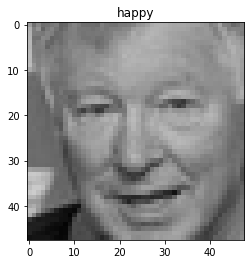

In [ ]:
img=[]
lab=[]
for images, labels in train_data.take(1):
  for i in range(len(images)):
    img.append(images[i].numpy().astype("uint8"))
    lab.append(index_to_class((int(labels[i]))))
    plt.imshow(img[i])
    plt.title(lab[i])
    #print(img[i].shape)

3.3 Build the Model

In [ ]:
import tensorflow as tf
import keras.api._v2.keras as keras 
import cv2
import os
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.optimizers import *
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

In [ ]:
from keras import layers, models
model = models.Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(48,48,3)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(7,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 50, 50, 3)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                        

*print out a graphic representation of the model*

In [ ]:
print (tf.keras.utils.plot_model)

<function plot_model at 0x7f78df1c64d0>


In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

In [ ]:
model.compile(optimizer="adam" ,loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 48, 48, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 48, 48, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='accuracy',verbose=1, patience=1,mode="max")
model_fit = model.fit(train_data ,epochs=5)  

*plot accuarcy & Loss*

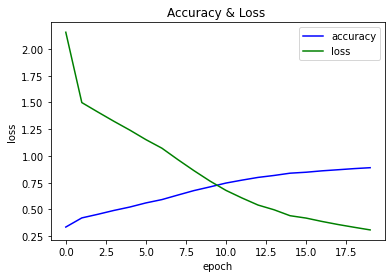

In [ ]:
plt.plot(model_fit.history['accuracy'],color="blue")
plt.plot(model_fit.history['loss'], color = "green")
plt.title('Accuracy & Loss ')
plt.ylabel('accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper right')


In [ ]:
model.evaluate(test_data)

221/221 [==============================] - 3s 13ms/step - loss: 1.8090 - accuracy: 0.2583


[1.8090132474899292, 0.25827908515930176]

In [ ]:
import joblib
import pickle
filename = "Emotion2 detection.joblib"
joblib.dump(model, filename)
print("Saved model to disk")


In [ ]:
import joblib
import pickle
filename = "Emotion2 detection.joblib"
loaded_model = joblib.load(filename)
loaded_model.summary()

In [ ]:
predictions=loaded_model.predict(test_data)
print(predictions)
predicted_class = np.argmax(predictions, axis=-1)
predictions.shape



[[1.24134560e-04 4.59190906e-28 2.22039167e-02 ... 7.13877679e-10
  5.07434487e-01 4.70223993e-01]
 [8.35083306e-01 1.80026914e-11 1.85673181e-02 ... 1.89268831e-02
  2.34358832e-02 3.28919515e-02]
 [6.49140894e-01 1.91027779e-04 1.12445861e-01 ... 4.64058539e-04
  2.35310748e-01 4.03360589e-09]
 ...
 [1.47439195e-07 2.38785381e-14 4.76214513e-02 ... 1.37232579e-04
  2.39418820e-01 7.12682247e-01]
 [4.16611246e-10 1.15620267e-27 5.15412912e-09 ... 1.38567225e-03
  1.79698660e-07 1.00418903e-12]
 [1.14306256e-01 3.16126053e-12 3.34100241e-06 ... 3.99500504e-02
  6.42259652e-03 2.54692338e-07]]


(7066, 7)

*Show as a dataframe, change the numerique columns to classes*

as reminder:

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
df = pd.DataFrame(predictions)
df['predicted_class']= predicted_class
df['Class']= [index_to_class(i) for i in predicted_class]
df

,0,1,2,3,4,5,6,predicted_class,Class
0,1.241346e-04,4.591909e-28,2.220392e-02,1.342073e-05,7.138777e-10,5.074345e-01,4.702240e-01,5,sad
1,8.350833e-01,1.800269e-11,1.856732e-02,7.109474e-02,1.892688e-02,2.343588e-02,3.289195e-02,0,anger
2,6.491409e-01,1.910278e-04,1.124459e-01,2.447370e-03,4.640585e-04,2.353107e-01,4.033606e-09,0,anger
3,5.268026e-08,7.026577e-12,2.343180e-05,4.356986e-09,3.501766e-05,9.999415e-01,5.091337e-09,5,sad
4,3.760227e-01,6.863791e-26,1.072616e-03,4.176738e-08,1.551632e-07,8.624235e-13,6.229044e-01,6,surprise
...,...,...,...,...,...,...,...,...,...
7061,7.699948e-05,4.406681e-23,9.958675e-17,9.992815e-01,6.415832e-04,4.102865e-09,1.496183e-24,3,happy
7062,8.529126e-03,1.650004e-08,9.887626e-01,2.180697e-03,5.273091e-04,3.324309e-07,4.913503e-12,2,fear
7063,1.474392e-07,2.387854e-14,4.762145e-02,1.401253e-04,1.372326e-04,2.394188e-01,7.126822e-01,6,surprise
7064,4.166112e-10,1.156203e-27,5.154129e-09,9.986141e-01,1.385672e-03,1.796987e-07,1.004189e-12,3,happy


In [ ]:
df_sum = pd.DataFrame(df['Class'])
df_sum

Since we have images with different sizes, we have o adjust the prediction and 

---

so the model to any size

Methode1//

In [ ]:
from PIL import Image
foo = Image.open("/content/photo.jpg")
# I downsize the image with an ANTIALIAS filter (gives the highest quality)
foo = foo.resize((48,48),Image.ANTIALIAS)
foo.save("methode1.jpg",optimize= True, quality=92)


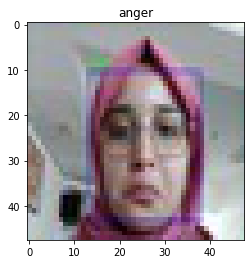

In [ ]:
image = tf.keras.preprocessing.image.load_img('/content/methode1.jpg', target_size=(48, 48))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
input_arr = input_arr.astype('float32') / 255. 
predictions = model.predict(input_arr)
predicted_class = np.argmax(predictions, axis=-1)
plt.title(index_to_class(predicted_class[0]))
plt.imshow(image)

Methode2//

In [ ]:
from PIL import Image
import PIL
import os
import glob

In [ ]:
base_width = 48
image = Image.open('/content/photo.jpg')
width_percent = (base_width / float(image.size[0]))
hsize = int((float(image.size[1]) * float(width_percent)))
image = image.resize((base_width, hsize), PIL.Image.ANTIALIAS)
base_height = 48
hpercent = (base_height / float(image.size[1]))
wsize = int((float(image.size[0]) * float(hpercent)))
image = image.resize((wsize, base_height), PIL.Image.ANTIALIAS)
image.save("methode2.jpg")

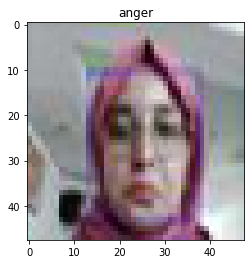

In [ ]:
image = tf.keras.preprocessing.image.load_img('/content/methode2.jpg', target_size=(48, 48))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
input_arr = input_arr.astype('float32')/255 
predictions = model.predict(input_arr)
predicted_class = np.argmax(predictions, axis=-1)
plt.title(index_to_class(predicted_class[0]))
plt.imshow(image)

---> Low resolution

Methode3

In [ ]:
from PIL import Image
import os
import PIL
import glob
import matplotlib.pyplot as plt


In [ ]:
image = Image.open('/content/photo.jpg')
print(image.size)

resized_image = image.resize((48,48))
print(resized_image.size)

(640, 480)
(48, 48)


Predict emotion 

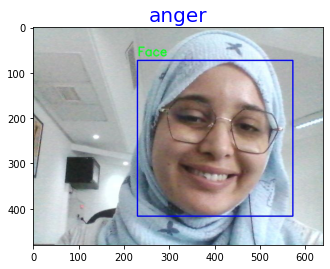

In [ ]:
input_arr = tf.keras.preprocessing.image.img_to_array(resized_image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
input_arr = input_arr.astype('float32')/255 
predictions = loaded_model.predict(input_arr)
predicted_class = np.argmax(predictions, axis=-1)
plt.title(index_to_class(predicted_class[0]),fontsize=20).set_color('Blue')
plt.imshow(image)

Recognize the person using model 1

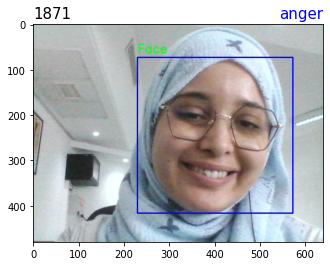

In [ ]:
input_arr = tf.keras.preprocessing.image.img_to_array(resized_image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
input_arr = input_arr.astype('float32')/255 
person = model1.predict(input_arr)
predicted_person = np.argmax(person, axis=-1)
plt.title(predicted_person[0],loc=('left'),fontsize=15)
plt.title(index_to_class(predicted_class[0]), loc=('right'),fontsize=15).set_color('Blue')
plt.imshow(image)